# 8. Systematic uncertainties

In this exercise, we will analyse the data of PKS 2155-304 from the H.E.S.S. DL3-DR1, compute its average spectrum and compare two spectral hypotheses. Then, we will assess the systematic uncertainties on the spectrum by studying the effect of a bias on the energy scale.

In [1]:
import matplotlib.pyplot as plt
import matplotlib.style as style
style.use('tableau-colorblind10')

import corner
import numpy as np
import os

from IPython.display import display
from scipy.stats import chi2, norm
from tqdm import tqdm

from astropy import units as u
from astropy.coordinates import SkyCoord, Angle
from astropy.table import Table
# from astroquery.simbad import Simbad

from gammapy.data import DataStore
from gammapy.datasets import Datasets, SpectrumDataset, SpectrumDatasetOnOff
from gammapy.estimators import FluxPointsEstimator
from gammapy.estimators.utils import resample_energy_edges
from gammapy.makers.utils import make_theta_squared_table
from gammapy.makers import (
    DatasetsMaker,
    SafeMaskMaker,
    SpectrumDatasetMaker,
    ReflectedRegionsBackgroundMaker,
)
from gammapy.maps import MapAxis, RegionGeom, WcsGeom
from gammapy.modeling import Fit, Parameter
from gammapy.modeling.models import (
    EBLAbsorptionNormSpectralModel,
    LogParabolaSpectralModel,
    PowerLawSpectralModel,
    SpectralModel,
    SkyModel,
)
from gammapy.utils import pbar
pbar.SHOW_PROGRESS_BAR = True
from gammapy.visualization import plot_spectrum_datasets_off_regions, plot_theta_squared_table

from regions import CircleSkyRegion

We first load the data for the H.E.S.S. DL3-DR1:

In [2]:
data_store = DataStore.from_dir(
    f"$GAMMAPY_DATA/hess-dl3-dr1"
)

In [3]:
display(data_store.obs_table)

OBS_ID,RA_PNT,DEC_PNT,GLON_PNT,GLAT_PNT,ZEN_PNT,ALT_PNT,AZ_PNT,OBJECT,RA_OBJ,DEC_OBJ,OFFSET_OBJ,ONTIME,LIVETIME,DEADC,TSTART,TSTOP,DATE-OBS,TIME-OBS,DATE-END,TIME-END,N_TELS,TELLIST,QUALITY,MUONEFF,EVENT_COUNT,TARGET_NAME,TARGET_TAG,TARGET_OFFSET,SAFE_ENERGY_LO,SAFE_ENERGY_HI
,deg,deg,deg,deg,deg,deg,deg,,deg,deg,deg,s,s,,s,s,,,,,,,,,,,,deg,TeV,TeV
int64,float32,float32,float32,float32,float32,float32,float32,bytes18,float32,float32,float32,float32,float32,float32,float64,float64,bytes10,bytes12,bytes10,bytes12,int64,bytes7,int64,float32,int64,bytes21,bytes14,float32,float32,float32
20136,228.6125,-58.771667,320.56754,-0.8857012,38.512962,51.487038,195.73102,MSH15-52,228.6125,-59.271667,0.5,1682.0,1521.0269,0.9042966,101962602.0,101964284.0,2004-03-26,02:57:46.184,2004-03-26,03:25:48.184,4,"1,2,3,4",0,1.2132596,11243,MSH 15-52,msh1552,0.38821736,0.40738028,100.0
20137,228.6125,-59.771667,320.04724,-1.7397733,40.21616,49.78384,199.6482,MSH15-52,228.6125,-59.271667,0.5,902.0,819.2054,0.90821,101964441.0,101965343.0,2004-03-26,03:28:25.184,2004-03-26,03:43:27.184,4,"1,2,3,4",0,1.2139559,5693,MSH 15-52,msh1552,0.6156251,0.40738028,100.0
20151,228.6125,-58.771667,320.56754,-0.8857012,37.164658,52.835342,190.97171,custom,228.6125,-59.271667,0.5,1683.0,1530.479,0.9093755,102047232.0,102048915.0,2004-03-27,02:28:16.184,2004-03-27,02:56:19.184,4,"1,2,3,4",0,1.2214733,10722,MSH 15-52,msh1552,0.38821736,0.40738028,100.0
20275,187.27792,2.552389,289.7155,64.849686,36.18243,53.81757,49.144917,3C 273,187.27792,2.052389,0.5,1683.0,1525.8447,0.90662193,103665036.0,103666719.0,2004-04-14,19:51:40.184,2004-04-14,20:19:43.184,4,"1,2,3,4",0,1.121256,10646,Off data,offdata,--,0.33113113,100.0
20282,228.6125,-58.771667,320.56754,-0.8857012,37.13134,52.86866,169.21602,MSH 15-5-02,228.6125,-59.271667,0.5,1687.0,1543.3231,0.9148329,103678269.0,103679956.0,2004-04-14,23:32:13.184,2004-04-15,00:00:20.184,4,"1,2,3,4",0,1.1495326,11063,MSH 15-52,msh1552,0.38821736,0.40738028,100.0
20283,228.6125,-59.771667,320.04724,-1.7397733,36.221436,53.778564,175.77263,MSH 15-5-02,228.6125,-59.271667,0.5,1683.0,1547.8253,0.9196823,103680087.0,103681770.0,2004-04-15,00:02:31.184,2004-04-15,00:30:34.184,4,"1,2,3,4",0,1.1512518,7628,MSH 15-52,msh1552,0.6156251,0.3801894,100.0
20301,228.6125,-58.771667,320.56754,-0.8857012,36.839905,53.160095,171.07347,MSH 15-5-02,228.6125,-59.271667,0.5,1683.0,1534.0626,0.9115048,103764878.0,103766561.0,2004-04-15,23:35:42.184,2004-04-16,00:03:45.184,4,"1,2,3,4",0,1.1503073,11624,MSH 15-52,msh1552,0.38821736,0.40738028,100.0
20302,228.6125,-59.771667,320.04724,-1.7397733,36.11632,53.88368,177.10521,MSH 15-5-02,228.6125,-59.271667,0.5,1682.0,1535.3478,0.9128108,103766698.0,103768380.0,2004-04-16,00:06:02.184,2004-04-16,00:34:04.184,4,"1,2,3,4",0,1.1493496,11794,MSH 15-52,msh1552,0.6156251,0.3801894,100.0


We set the properties of the source of interest. Bonus: we use Virtual Observatory services to query the source parameters.

In [4]:
src = dict()
src['Name'] = 'PKS 2155-304'
src['Position'] = SkyCoord.from_name(src['Name'])

try:
    simbad = Simbad()
    simbad.add_votable_fields("z_value")
    query = simbad.query_object(src['Name'])
    src['Redshift'] = query["Z_VALUE"].data[0]
except NameError:
    src['Redshift'] = 0.116

In [5]:
#src = dict()
#src['Name'] = 'Crab Nebula'
#src['Position'] = SkyCoord.from_name(src['Name'])
#
#try:
#    simbad = Simbad()
#    simbad.add_votable_fields("z_value")
#    query = simbad.query_object(src['Name'])
#    src['Redshift'] = query["Z_VALUE"].data[0]
#except NameError:
#    pass

We select a sub-sample of H.E.S.S. data acquired on our source:

In [6]:
selection = dict(
    type="sky_circle",
    frame="icrs",
    lon=src['Position'].ra,
    lat=src['Position'].dec,
    radius="3 deg",
)
selected_obs_table = data_store.obs_table.select_observations(selection)
obs_ids = selected_obs_table["OBS_ID"]
observations = data_store.get_observations(obs_ids)

Obs Id:   0%|          | 0/21 [00:00<?, ?it/s]

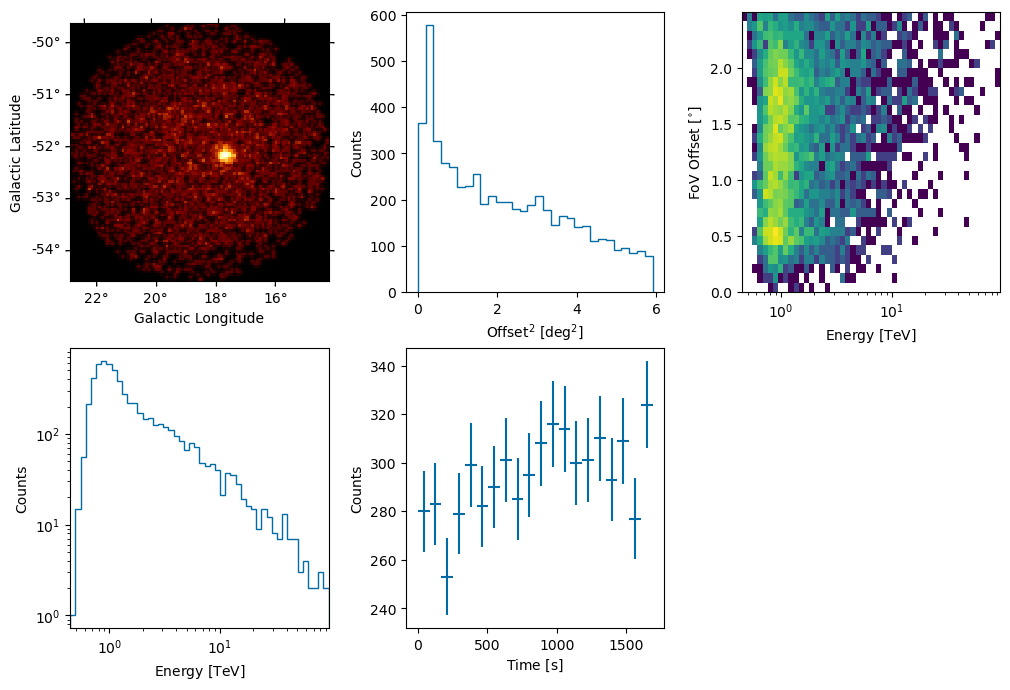

In [7]:
obs = data_store.obs(obs_ids[0])
obs.events.select_offset([0, 2.5] * u.deg).peek()

In [9]:
on_region_radius = Angle("0.1 deg")

on_region = CircleSkyRegion(center=src['Position'], radius=on_region_radius)
exclusion_region = CircleSkyRegion(center=src['Position'],radius=0.5 * u.deg)
geom = WcsGeom.create(
    npix=(120, 120), binsz=0.05, skydir=src['Position'], proj="TAN", frame="icrs"
)
exclusion_mask = ~geom.region_mask([exclusion_region])

# Data reduction

Let's perform a 1D analysis of the data.

In [10]:
energy_axis = MapAxis.from_energy_bounds(0.02, 200, nbin=20, per_decade=True, unit="TeV", name="energy")
energy_axis_true = MapAxis.from_energy_bounds(0.005, 300, nbin=30, per_decade=True, unit="TeV", name="energy_true")

geom = RegionGeom.create(region=on_region, axes=[energy_axis])

dataset_empty = SpectrumDataset.create(geom=geom, energy_axis_true=energy_axis_true)
dataset_maker = SpectrumDatasetMaker(containment_correction=True, selection=["counts", "exposure", "edisp"])

bkg_maker = ReflectedRegionsBackgroundMaker(exclusion_mask=exclusion_mask)
safe_mask_maker = SafeMaskMaker(methods=["bkg-peak", "aeff-max"], aeff_percent=10)

In [11]:
%%time

# Parallel version
makers = [dataset_maker, bkg_maker, safe_mask_maker]  # the order matters
datasets_maker = DatasetsMaker(makers, stack_datasets=False, n_jobs=8)
datasets = datasets_maker.run(dataset_empty, observations)

Data reduction:   0%|          | 0/21 [00:00<?, ?it/s]

CPU times: user 1.12 s, sys: 111 ms, total: 1.23 s
Wall time: 3.18 s


In [12]:
%%time

# Non-parallel version

datasets = Datasets()

for obs in observations:
    dataset = dataset_maker.run(
        dataset_empty.copy(name=f"obs-{obs.obs_id}"), obs
    )
    dataset_on_off = bkg_maker.run(dataset, obs)
    dataset_on_off = safe_mask_maker.run(dataset_on_off, obs)
    datasets.append(dataset_on_off)

CPU times: user 8.27 s, sys: 59.6 ms, total: 8.33 s
Wall time: 8.34 s


/cvmfs/sw.hess-experiment.eu/software/conda/envs/gammapy-1.2/lib/python3.10/site-packages/regions/shapes/circle.py:161: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  return Circle(xy=xy, radius=radius, **mpl_kwargs)


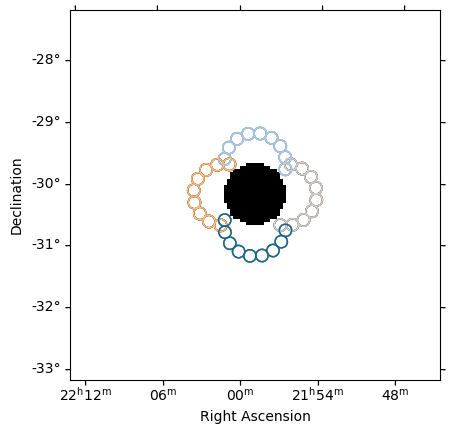

In [13]:
plt.figure()
ax = exclusion_mask.plot()
on_region.to_pixel(ax.wcs).plot(ax=ax, edgecolor="k")
plot_spectrum_datasets_off_regions(ax=ax, datasets=datasets)
plt.show()

In [14]:
info_table = datasets.info_table(cumulative=True)

display(info_table)

name,counts,excess,sqrt_ts,background,npred,npred_background,npred_signal,exposure_min,exposure_max,livetime,ontime,counts_rate,background_rate,excess_rate,n_bins,n_fit_bins,stat_type,stat_sum,counts_off,acceptance,acceptance_off,alpha
,,,,,,,,m2 s,m2 s,s,s,1 / s,1 / s,1 / s,,,,,,,,
str7,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,str5,float64,int64,float64,float64,float64
stacked,177,164.44444274902344,21.24011050904081,12.555556297302246,29.000000206530096,29.000000206530096,nan,2307815.0,956501696.0,1645.9436731394428,1689.000000000005,0.10753709430553808,0.007628181025997085,0.09990891270013215,80,48,wstat,481.56336709031734,113,48.0,431.9999694824219,0.111111119389534
stacked,805,781.7777709960938,52.14816944943998,23.22222328186035,101.40000219471752,101.40000219471752,nan,2723258.0,1531970048.0,3242.0454647149895,3378.0000000000005,0.24830003427196481,0.007162830853114466,0.24113720165390104,80,51,wstat,2793.218304471906,209,51.0,458.9999694824219,0.111111119389534
stacked,2038,2003.0,87.17254091474663,35.0,235.30000362366437,235.30000362366437,nan,431920.1875,2049040000.0,4825.489054074511,5065.999999999999,0.42234061193842487,0.007253150842907199,0.4150874610955177,80,53,wstat,7730.951306391487,315,53.0,477.0,0.1111111119389534
stacked,3613,3559.666748046875,117.39139074936415,53.333335876464844,409.30000928647814,409.30000928647814,nan,1844916.25,2468012800.0,6386.866192122923,6756.000000000001,0.5656921393556046,0.008350470210608474,0.5573416822849833,80,56,wstat,13934.537541285988,480,56.0,503.9999694824219,0.111111119389534
stacked,5002,4933.77783203125,138.88171654429308,68.22222900390625,561.6000083041191,561.6000083041191,nan,333416.5,2825196032.0,7954.743777347735,8445.000000000005,0.628807179716323,0.008576294964795568,0.6202308924243273,80,57,wstat,19458.16321810762,614,57.0,512.9999389648438,0.111111119389534
stacked,6385,6296.888671875,156.78729256007213,88.11111450195312,717.8000137148051,717.8000137148051,nan,2486206.5,3139006208.0,9517.102900041273,10133.000000000004,0.6708974429573846,0.009258186596004022,0.6616392339151542,80,58,wstat,24780.022192979533,793,58.0,522.0,0.1111111119389534
stacked,7395,7285.33349609375,167.8915173847777,109.66667175292969,838.2000122590363,838.2000122590363,nan,8441042.0,3429723136.0,11083.773701896891,11822.0,0.6671915359237631,0.009894344173966778,0.6572972068932559,80,59,wstat,28418.92026845774,987,59.0,530.9999389648438,0.111111119389534
stacked,8609,8474.22265625,180.43793994502155,134.77777099609375,982.2000136229394,982.2000136229394,nan,16440726.0,3710390016.0,12648.486569276083,13510.000000000004,0.6806347900081395,0.010655644077092739,0.6699791797094827,80,60,wstat,32864.57087150862,1213,60.0,540.0000610351562,0.1111111044883728


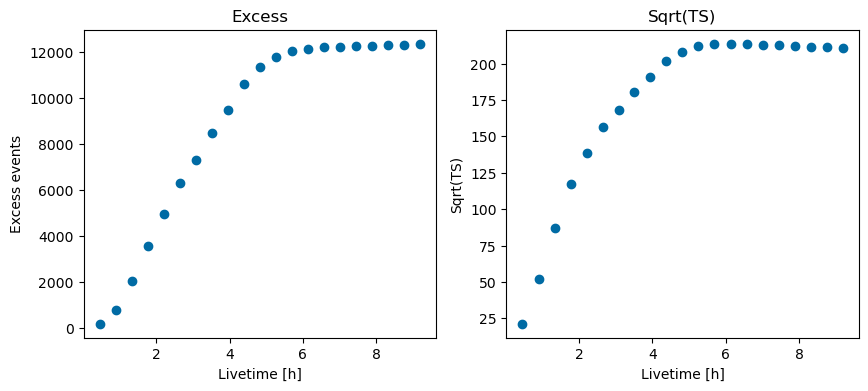

In [15]:
fig, (ax_excess, ax_sqrt_ts) = plt.subplots(figsize=(10, 4), ncols=2, nrows=1)
ax_excess.plot(
    info_table["livetime"].to("h"),
    info_table["excess"],
    marker="o",
    ls="none",
)

ax_excess.set_title("Excess")
ax_excess.set_xlabel("Livetime [h]")
ax_excess.set_ylabel("Excess events")

ax_sqrt_ts.plot(
    info_table["livetime"].to("h"),
    info_table["sqrt_ts"],
    marker="o",
    ls="none",
)

ax_sqrt_ts.set_title("Sqrt(TS)")
ax_sqrt_ts.set_xlabel("Livetime [h]")
ax_sqrt_ts.set_ylabel("Sqrt(TS)")

plt.show()

In [ ]:
theta2_axis = MapAxis.from_bounds(0, 0.1, nbin=50, interp="lin", unit="deg2")

theta2_table = make_theta_squared_table(
    observations=observations,
    position=src['Position'],
    theta_squared_axis=theta2_axis,
)

on_region_radius = Angle("0.1 deg")

fig = plt.figure(figsize=(8, 5))
plot_theta_squared_table(theta2_table)
for ax in fig.get_axes():
    ax.axvline(on_region_radius.value**2, color="red", linestyle="--", label="ON region")
    ax.legend()
plt.show()

In [16]:
dataset_stack = datasets.stack_reduce(name="hess")

# Fit stacked spectrum

We will fit the overall spectrum of PKS 2155-304, under two hypotheses:
* a simple power-law
* a log-parabola

We will judge which hypotheses reperesent best the data by comparing the fit statistics.

In [17]:
ebl_model = 'dominguez'

if 'GAMMAPY_DATA' not in os.environ:
    os.environ['GAMMAPY_DATA'] = '/sps/hess/prod/gammapy/datasets/1.2'

# absorption = EBLAbsorptionNormSpectralModel.read_builtin(ebl_model, redshift=src['Redshift'])

In [18]:
reference_energy = 300. * u.Unit("GeV")

In [19]:
dataset_stack_pl = dataset_stack.copy(name="hess")

spectral_model_pl = PowerLawSpectralModel(amplitude=1e-7 * u.Unit("cm-2 s-1 TeV-1"),
                                          reference=reference_energy,
                                          index=2.
                                         )
spectral_model_pl.parameters["amplitude"].frozen = False
spectral_model_pl.parameters["amplitude"].min = 0.
spectral_model_pl.parameters["index"].frozen = False

source_pl = SkyModel(
    spectral_model=spectral_model_pl,
    name=src['Name'],
)

dataset_stack_pl.models = source_pl
print(dataset_stack_pl)

SpectrumDatasetOnOff
--------------------

  Name                            : hess 

  Total counts                    : 12654 
  Total background counts         : 301.78
  Total excess counts             : 12352.22

  Predicted counts                : 1108792.77
  Predicted background counts     : 272.31
  Predicted excess counts         : 1108520.47

  Exposure min                    : 3.03e+07 m2 s
  Exposure max                    : 9.43e+09 m2 s

  Number of total bins            : 80 
  Number of fit bins              : 60 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 2094251.08

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 2

  Component 0: SkyModel
  
    Name                      : PKS 2155-304
    Datasets names            : None
    Spectral model type       : PowerLawSpectralModel
    Spatial  model type       : 
    Temporal model type       : 
    Parameters:
      index

In [20]:
%%time

fit_pl = Fit()
result_pl = fit_pl.run(datasets=dataset_stack_pl)

# we make a copy here to compare it later
model_best_pl = source_pl.copy(name=src['Name'])

CPU times: user 330 ms, sys: 27.2 ms, total: 358 ms
Wall time: 381 ms


In [21]:
dataset_stack_lp = dataset_stack.copy(name="hess")

spectral_model_lp = LogParabolaSpectralModel(amplitude=1e-7 * u.Unit("cm-2 s-1 TeV-1"),
                                             reference=reference_energy,
                                             alpha=2.,
                                             beta=0.01,
                                            )
spectral_model_lp.parameters["amplitude"].frozen = False
spectral_model_lp.parameters["amplitude"].min = 0.
spectral_model_lp.parameters["alpha"].frozen = False
spectral_model_lp.parameters["beta"].frozen = False
spectral_model_lp.parameters["beta"].min = 0.

source_lp = SkyModel(
    spectral_model=spectral_model_lp,
    name=src['Name'],
)

dataset_stack_lp.models = source_lp
print(dataset_stack_lp)

SpectrumDatasetOnOff
--------------------

  Name                            : hess 

  Total counts                    : 12654 
  Total background counts         : 301.78
  Total excess counts             : 12352.22

  Predicted counts                : 1070292.91
  Predicted background counts     : 272.31
  Predicted excess counts         : 1070020.60

  Exposure min                    : 3.03e+07 m2 s
  Exposure max                    : 9.43e+09 m2 s

  Number of total bins            : 80 
  Number of fit bins              : 60 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 2017404.11

  Number of models                : 1 
  Number of parameters            : 4
  Number of free parameters       : 3

  Component 0: SkyModel
  
    Name                      : PKS 2155-304
    Datasets names            : None
    Spectral model type       : LogParabolaSpectralModel
    Spatial  model type       : 
    Temporal model type       : 
    Parameters:
      am

In [22]:
%%time

fit_lp = Fit()
result_lp = fit_lp.run(datasets=dataset_stack_lp)

# we make a copy here to compare it later
model_best_lp = source_lp.copy(name=src['Name'])

CPU times: user 305 ms, sys: 2.07 ms, total: 307 ms
Wall time: 306 ms


In [23]:
def sigma_lp_vs_pl(df=1):
    ts_pl = result_pl.total_stat
    ts_lp = result_lp.total_stat
    Delta_TS = ts_pl-ts_lp
    p_value = chi2.sf(Delta_TS, df=df)
    sigma = norm.isf(0.5*p_value)  # 0.5 only for 1-sided hypothesis on curvature parameter (which is constrained positive)
    return sigma

In [24]:
sigma_lp_pl = sigma_lp_vs_pl()

criterion_lp_pl_selection = 3.0  # How many sigma to prefer LP over PL ?

if sigma_lp_pl >= criterion_lp_pl_selection:
    print(f"Log-parabola preferred over a power-law at {sigma_lp_pl:.2f} sigmas.")
    result = result_lp
    fit = fit_lp
    dataset_stack = dataset_stack_lp.copy(name="hess")
    model_best = source_lp.copy(name=src['Name'])
else:
    print(f"Log-parabola *not* preferred over a power-law (Delta TS(log-parabola vs power-law)={sigma_lp_pl:.2f} sigmas).")
    result = result_pl
    fit = fit_pl
    dataset_stack = dataset_stack_pl.copy(name="hess")
    model_best = source_pl.copy(name=src['Name'])
    
source_model = SkyModel(
    spectral_model=model_best.spectral_model,
    name=src['Name'],
)
dataset_stack.models = source_model

Log-parabola preferred over a power-law at 8.62 sigmas.


# Compute flux points

In [26]:
n_jobs = 8
energy_edges = resample_energy_edges(dataset_stack, conditions={'sqrt_ts_min': 2.})

fpe = FluxPointsEstimator(
    energy_edges=energy_edges,
    source=src['Name'],
    selection_optional=["errn-errp", "ul", "scan"],
    fit=fit,
    n_jobs=n_jobs,
)
flux_points = fpe.run([dataset_stack])

Energy bins:   0%|          | 0/27 [00:00<?, ?it/s]

Reoptimize = False ignored for iminuit backend
Reoptimize = False ignored for iminuit backend
Reoptimize = False ignored for iminuit backend
Reoptimize = False ignored for iminuit backend
Reoptimize = False ignored for iminuit backend
Reoptimize = False ignored for iminuit backend
Reoptimize = False ignored for iminuit backend
Reoptimize = False ignored for iminuit backend
Reoptimize = False ignored for iminuit backend
Reoptimize = False ignored for iminuit backend
Reoptimize = False ignored for iminuit backend
Reoptimize = False ignored for iminuit backend
Reoptimize = False ignored for iminuit backend
Reoptimize = False ignored for iminuit backend


Scan values:   0%|          | 0/11 [00:00<?, ?it/s]

Scan values:   0%|          | 0/11 [00:00<?, ?it/s]

Scan values:   0%|          | 0/11 [00:00<?, ?it/s]

Reoptimize = False ignored for iminuit backend
Reoptimize = False ignored for iminuit backend


Scan values:   0%|          | 0/11 [00:00<?, ?it/s]

Scan values:   0%|          | 0/11 [00:00<?, ?it/s]

Scan values:   0%|          | 0/11 [00:00<?, ?it/s]

Scan values:   0%|          | 0/11 [00:00<?, ?it/s]

Scan values:   0%|          | 0/11 [00:00<?, ?it/s]

Reoptimize = False ignored for iminuit backend
Reoptimize = False ignored for iminuit backend
Reoptimize = False ignored for iminuit backend
Reoptimize = False ignored for iminuit backend
Reoptimize = False ignored for iminuit backend
Reoptimize = False ignored for iminuit backend
Reoptimize = False ignored for iminuit backend
Reoptimize = False ignored for iminuit backend
Reoptimize = False ignored for iminuit backend
Reoptimize = False ignored for iminuit backend
Reoptimize = False ignored for iminuit backend


Scan values:   0%|          | 0/11 [00:00<?, ?it/s]

Reoptimize = False ignored for iminuit backend


Scan values:   0%|          | 0/11 [00:00<?, ?it/s]

Scan values:   0%|          | 0/11 [00:00<?, ?it/s]

Reoptimize = False ignored for iminuit backend


Scan values:   0%|          | 0/11 [00:00<?, ?it/s]

Scan values:   0%|          | 0/11 [00:00<?, ?it/s]

Reoptimize = False ignored for iminuit backend
Reoptimize = False ignored for iminuit backend
Reoptimize = False ignored for iminuit backend


Scan values:   0%|          | 0/11 [00:00<?, ?it/s]

Scan values:   0%|          | 0/11 [00:00<?, ?it/s]

Reoptimize = False ignored for iminuit backend
Reoptimize = False ignored for iminuit backend
Reoptimize = False ignored for iminuit backend


Scan values:   0%|          | 0/11 [00:00<?, ?it/s]

Reoptimize = False ignored for iminuit backend
Reoptimize = False ignored for iminuit backend
Reoptimize = False ignored for iminuit backend
Reoptimize = False ignored for iminuit backend
Reoptimize = False ignored for iminuit backend
Reoptimize = False ignored for iminuit backend


Scan values:   0%|          | 0/11 [00:00<?, ?it/s]

Scan values:   0%|          | 0/11 [00:00<?, ?it/s]

Reoptimize = False ignored for iminuit backend
Reoptimize = False ignored for iminuit backend
Reoptimize = False ignored for iminuit backend


Scan values:   0%|          | 0/11 [00:00<?, ?it/s]

Scan values:   0%|          | 0/11 [00:00<?, ?it/s]

Reoptimize = False ignored for iminuit backend
Reoptimize = False ignored for iminuit backend
Reoptimize = False ignored for iminuit backend


Scan values:   0%|          | 0/11 [00:00<?, ?it/s]

Reoptimize = False ignored for iminuit backend


Scan values:   0%|          | 0/11 [00:00<?, ?it/s]

Reoptimize = False ignored for iminuit backend
Reoptimize = False ignored for iminuit backend


Scan values:   0%|          | 0/11 [00:00<?, ?it/s]

Scan values:   0%|          | 0/11 [00:00<?, ?it/s]

Reoptimize = False ignored for iminuit backend
Reoptimize = False ignored for iminuit backend
Reoptimize = False ignored for iminuit backend


Scan values:   0%|          | 0/11 [00:00<?, ?it/s]

Scan values:   0%|          | 0/11 [00:00<?, ?it/s]

Reoptimize = False ignored for iminuit backend


Scan values:   0%|          | 0/11 [00:00<?, ?it/s]

# Spectral energy distribution

We will produce an SED with the best-fit model and results.

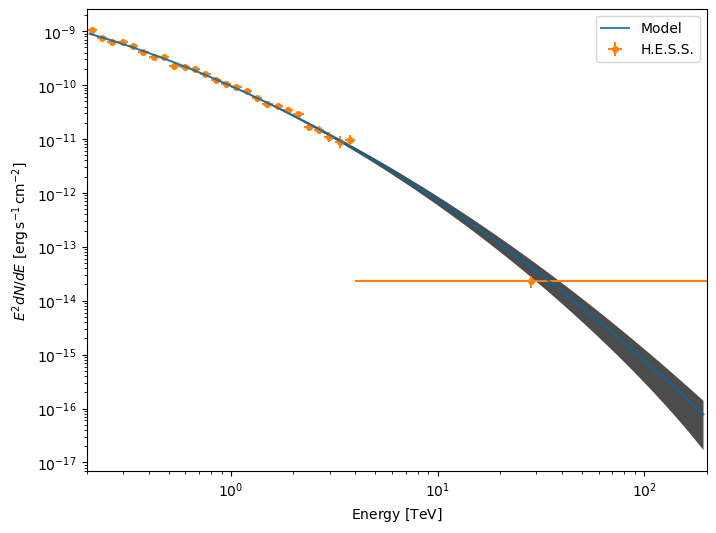

In [27]:
fig, ax = plt.subplots(figsize=(8, 6))

plot_kwargs = {
    "energy_bounds": [energy_edges[0], energy_edges[-1]],
    "sed_type": "e2dnde",  # "dnde"
    "yunits": u.Unit("erg cm-2 s-1"),  # u.Unit("cm-2 s-1 TeV-1")
    "ax": ax,
}

spec = dataset_stack.models[src['Name']].spectral_model

# plot best-fit model
spec.plot(
    ax=plot_kwargs['ax'],
    energy_bounds=plot_kwargs['energy_bounds'],
    sed_type=plot_kwargs['sed_type'],
    label="Model",
    alpha=0.8,
    zorder=3,
)
spec.plot_error(
    ax=plot_kwargs['ax'],
    energy_bounds=plot_kwargs['energy_bounds'],
    sed_type=plot_kwargs['sed_type'],
    alpha=0.7,
    zorder=2,
)

flux_points.plot(ax=plot_kwargs['ax'],
             sed_type=plot_kwargs['sed_type'],
             label="H.E.S.S.")

ylabel = ax.get_ylabel()
ax.set_ylabel(ylabel.replace('e2dnde', '$E^2 dN/dE$'))
ax.legend()
plt.show()

# Systematics study

Now, we will define a custom spectral model by introducing a nuisance parameter on the energy scale, and study the systematic effet of a bias on this parameter.

In [ ]:
# Define some custom biased spectral models
#
# See https://github.com/bkhelifi/CTAO-CTAC_Meeting_Granada_2023/blob/main/Crab_simulations_systematic_errors_Solution.ipynb

class BiasedPowerLawSpectralModel(SpectralModel):
    tag = "BiasedPowerLawSpectralModel"
    amplitude = Parameter("amplitude", "1e-12 cm-2 s-1 TeV-1", min=0, is_norm=True)
    index = Parameter("index", 2.5, min=0)
    reference = Parameter("reference", "1 TeV", frozen=True)
    bias = Parameter("bias", 1., min=0.)
        
    @staticmethod
    def evaluate(energy, amplitude, index, reference, bias):
        energy = bias.value * energy
        pwl = PowerLawSpectralModel.evaluate(
            energy=energy,
            index=index,
            amplitude=amplitude,
            reference=reference,
        )
        return pwl

class BiasedLogParabolaSpectralModel(SpectralModel):
    tag = "BiasedLogParabolaSpectralModel"
    amplitude = Parameter("amplitude", "1e-12 cm-2 s-1 TeV-1", min=0, is_norm=True)
    alpha = Parameter("alpha", 2.5, min=0)
    beta = Parameter("beta", 0.5)
    reference = Parameter("reference", "1 TeV", frozen=True)
    bias = Parameter("bias", 1., min=0.)
        
    @staticmethod
    def evaluate(energy, amplitude, alpha, beta, reference, bias):
        energy = bias.value * energy
        logpwl = LogParabolaSpectralModel.evaluate(
            energy=energy,
            alpha=alpha,
            beta=beta,
            amplitude=amplitude,
            reference=reference,
        )
        return logpwl

In [28]:
# Define the biased model, based on the best model shape obtained above (PL or LP)

if sigma_lp_pl >= criterion_lp_pl_selection:
    spectral_model_biased = BiasedLogParabolaSpectralModel(
        amplitude=model_best.spectral_model.amplitude,
        reference=model_best.spectral_model.reference,
        alpha=model_best.spectral_model.alpha,
        beta=model_best.spectral_model.beta,
    )
    spectral_model_biased.parameters["alpha"].frozen = False
    spectral_model_biased.parameters["beta"].frozen = False
    spectral_model_biased.parameters["beta"].min = 0.
else:
    spectral_model_biased = BiasedPowerLawSpectralModel(
        amplitude=model_best.spectral_model.amplitude,
        reference=model_best.spectral_model.reference,
        index=model_best.spectral_model.index,
    )
    spectral_model_biased.parameters["index"].frozen = False

spectral_model_biased.parameters["amplitude"].frozen = False
spectral_model_biased.parameters["amplitude"].min = 0.

biased_model = SkyModel(
    spectral_model=spectral_model_biased,
    name=f"biased_{src['Name']}",
)
print(biased_model)

SkyModel

  Name                      : biased_PKS 2155-304
  Datasets names            : None
  Spectral model type       : BiasedLogParabolaSpectralModel
  Spatial  model type       : 
  Temporal model type       : 
  Parameters:
    amplitude                     :   3.98e-09   +/- 4.7e-11 1 / (TeV s cm2)
    alpha                         :      3.265   +/-    0.04             
    beta                          :      0.183   +/-    0.02             
    reference             (frozen):    300.000       GeV         
    bias                          :      1.000   +/-    0.00             




In [29]:
# Definition of reference dataset
reference_dataset = dataset_stack.copy(name="hess")

# Fake counts taking bias into account
simulated_biased_datasets = []
n_sim = 1000  # 1000
energy_bias = 10./100.

# Fit the unbiased model
results_biased = []
fit_biased = Fit()

for i in tqdm(range(n_sim)):
    ds = reference_dataset
    # Randomize random bias
    biased_model.spectral_model.bias.value = np.random.normal(loc=1.0, scale=energy_bias)
    biased_model.spectral_model.bias.frozen = True
    
    # Set the model on the ON-OFF dataset using the *biased* model
    ds.models = [biased_model]

    ds.fake(random_state='random-seed', npred_background=reference_dataset.background)
    
    # We use a copy of the best (PL or LP) *unbiased* model
    ds.models = [source_model.copy(name=src['Name'])]
    
    fit_result = fit_biased.run([ds])

    if fit_result.success:
        par_dict = {}
        for par in fit_result.parameters.free_parameters:
            par_dict[par.name] = par.quantity
        results_biased.append(par_dict)
        
    simulated_biased_datasets.append(ds)

100%|██████████████████████████████████████████████████████████████████████████| 1000/1000 [02:45<00:00,  6.05it/s]


In [30]:
fitted_params_with_energy_bias = Table(results_biased).to_pandas()
biased_mean = fitted_params_with_energy_bias.mean()
biased_uncertainty = fitted_params_with_energy_bias.std()

In [31]:
for par in result.models[src['Name']].spectral_model.parameters.free_parameters:
    statistic_uncertainty = par.error * par.unit
    total_uncertainty = biased_uncertainty[par.name] * par.unit
    systematic_uncertainty = np.sqrt(np.abs(total_uncertainty**2 - statistic_uncertainty**2))
    print(f"{par.name} : {par.quantity.value:.3e} +/-\t"
          f" {statistic_uncertainty.value:.3e} (stat.) +/-\t"
          f" {systematic_uncertainty.value:.3e} (syst.) {par.quantity.unit}")

amplitude : 3.985e-09 +/-	 4.700e-11 (stat.) +/-	 1.545e-09 (syst.) 1 / (TeV s cm2)
alpha : 3.265e+00 +/-	 3.601e-02 (stat.) +/-	 3.274e-02 (syst.) 
beta : 1.826e-01 +/-	 2.332e-02 (stat.) +/-	 2.261e-03 (syst.) 


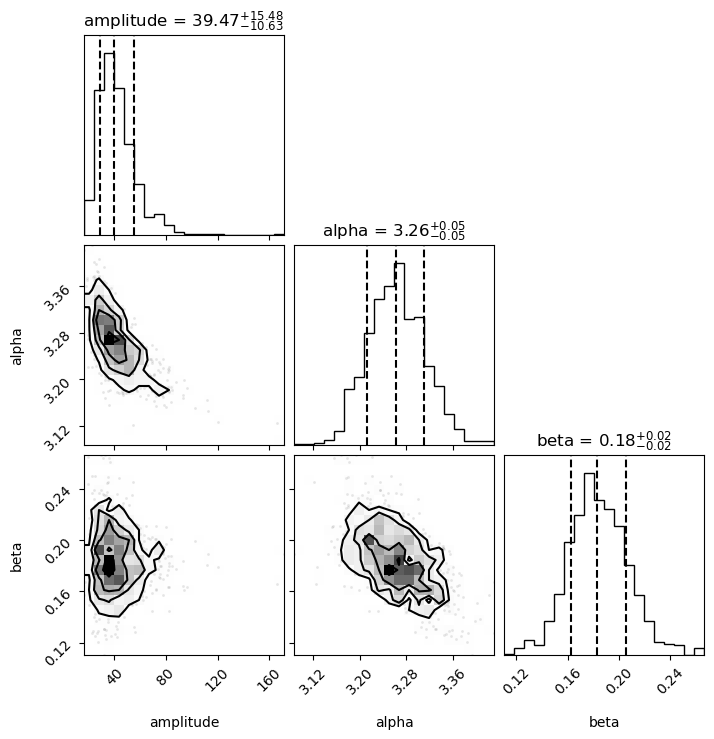

In [32]:
fitted_params_with_energy_bias['amplitude'] *= 1e10

figure = corner.corner(fitted_params_with_energy_bias,
                       quantiles=[0.16, 0.5, 0.84],
                       show_titles=True,
                       title_kwargs={"fontsize": 12})

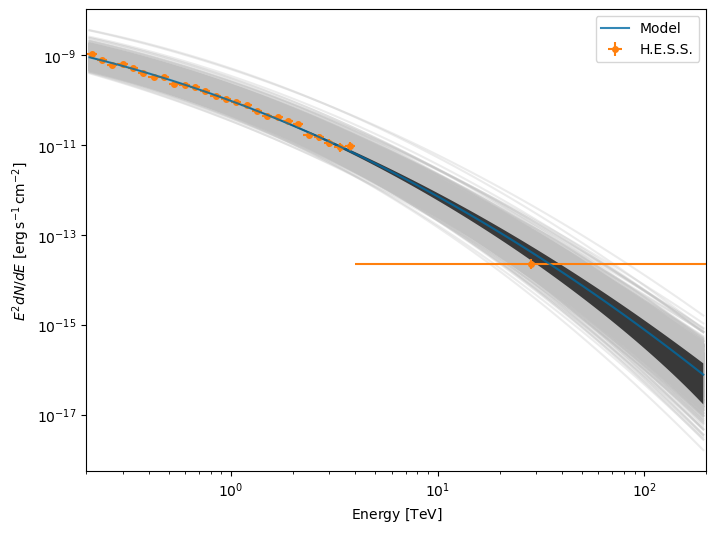

In [33]:
fig, ax = plt.subplots(figsize=(8, 6))

plot_kwargs = {
    "energy_bounds": [energy_edges[0], energy_edges[-1]],
    "sed_type": "e2dnde",  # "dnde"
    "yunits": u.Unit("erg cm-2 s-1"),  # u.Unit("cm-2 s-1 TeV-1")
    "ax": ax,
}

spec = dataset_stack.models[src['Name']].spectral_model

# plot best-fit model
spec.plot(
    ax=plot_kwargs['ax'],
    energy_bounds=plot_kwargs['energy_bounds'],
    sed_type=plot_kwargs['sed_type'],
    label="Model",
    alpha=0.8,
    zorder=3,
)
spec.plot_error(
    ax=plot_kwargs['ax'],
    energy_bounds=plot_kwargs['energy_bounds'],
    sed_type=plot_kwargs['sed_type'],
    alpha=0.7,
    zorder=2,
)

for i, result_biased in enumerate(results_biased):
    if sigma_lp_pl >= criterion_lp_pl_selection:
        spec_biased = LogParabolaSpectralModel(
            amplitude=result_biased["amplitude"],
            reference=reference_energy,
            alpha=result_biased["alpha"],
            beta=result_biased["beta"],
        )
    else:
        spec_biased = PowerLawSpectralModel(
            amplitude=result_biased["amplitude"],
            reference=reference_energy,
            index=result_biased["index"],
        )

    spec_biased.plot(
        ax=plot_kwargs['ax'],
        energy_bounds=plot_kwargs['energy_bounds'],
        sed_type=plot_kwargs['sed_type'],
        # label="Biased model",
        alpha=0.3,
        color='silver',
        zorder=1,
    )

flux_points.plot(ax=plot_kwargs['ax'],
             sed_type=plot_kwargs['sed_type'],
             label="H.E.S.S.")

#ax.set_xlim(plot_kwargs['energy_bounds'])
#ax.set_xlim([0.1, 300.] * u.TeV)
#ax.set_ylim(
#    top=1.e-9 * u.Unit("erg cm-2 s-1"),
#    bottom=1.e-19 * u.Unit("erg cm-2 s-1"),
#)
ylabel = ax.get_ylabel()
ax.set_ylabel(ylabel.replace('e2dnde', '$E^2 dN/dE$'))
ax.legend()
plt.show()

Scan values:   0%|          | 0/20 [00:00<?, ?it/s]

Scan values:   0%|          | 0/20 [00:00<?, ?it/s]

Scan values:   0%|          | 0/20 [00:00<?, ?it/s]

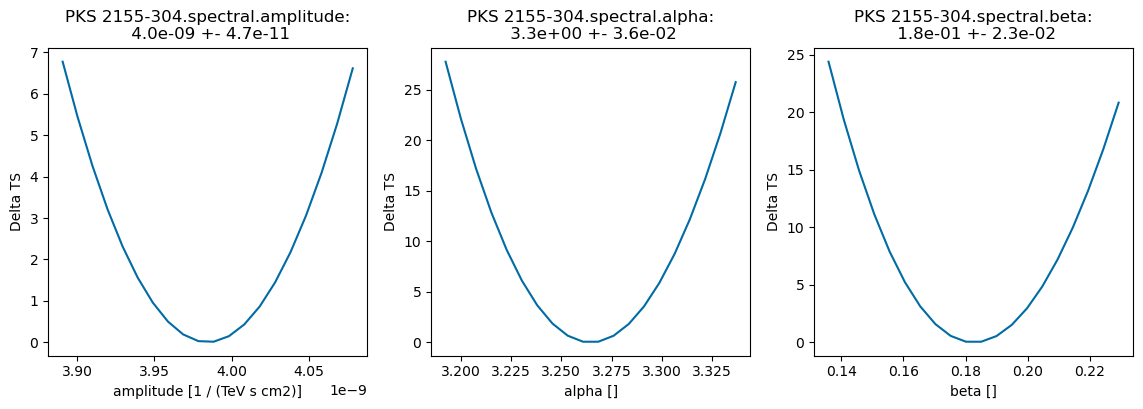

In [34]:
# Likelihood profiles

total_stat = result.total_stat

ds = Datasets([dataset_stack])

fig, axes = plt.subplots(nrows=1, ncols=len(ds.parameters.free_parameters), figsize=(14, 4))

for ax, par in zip(axes, ds.parameters.free_parameters):
    par.scan_n_values = 20
    idx = ds.parameters.index(par)
    name = ds.models.parameters_unique_names[idx]
    profile = fit.stat_profile(datasets=ds, parameter=par)
    ax.plot(profile[f"{name}_scan"], profile["stat_scan"] - total_stat)
    ax.set_xlabel(f"{par.name} [{par.unit}]")
    ax.set_ylabel("Delta TS")
    ax.set_title(f"{name}:\n {par.value:.1e} +- {par.error:.1e}")
plt.show()

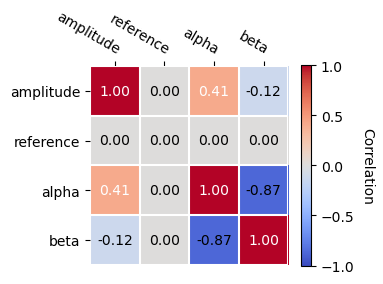

In [35]:
# Parameters correlations

result.models.covariance.plot_correlation()
plt.show()